In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [44]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [45]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [48]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)

Pneumonia: 3883
Normal: 1349


PNEUMONIA


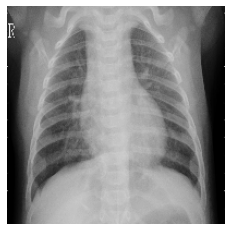

In [49]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [50]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [51]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [52]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [39]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same')zz)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

#model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 256)     2560      
_________________________________________________________________
activation_10 (Activation)   (None, 200, 200, 256)     0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 256)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 100, 256)     400       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      147520    
_________________________________________________________________
activation_11 (Activation)   (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 64)       

In [53]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
376/376 [==============================] - 28s 74ms/step - loss: 0.3815 - acc: 0.8193 - val_loss: 0.3183 - val_acc: 0.8681
Epoch 2/15
376/376 [==============================] - 28s 74ms/step - loss: 0.3354 - acc: 0.8488 - val_loss: 0.5790 - val_acc: 0.7479
Epoch 3/15
376/376 [==============================] - 28s 75ms/step - loss: 0.3201 - acc: 0.8627 - val_loss: 0.3356 - val_acc: 0.8745
Epoch 4/15
376/376 [==============================] - 28s 75ms/step - loss: 0.3026 - acc: 0.8693 - val_loss: 0.2968 - val_acc: 0.8606
Epoch 5/15
376/376 [==============================] - 28s 76ms/step - loss: 0.2785 - acc: 0.8757 - val_loss: 0.2700 - val_acc: 0.8989
Epoch 6/15
376/376 [==============================] - 29s 76ms/step - loss: 0.2719 - acc: 0.8893 - val_loss: 0.2567 - val_acc: 0.9064
Epoch 7/15
376/376 [==============================] - 29s 76ms/step - loss: 0.2707 - acc: 0.8845 - val_loss: 0.2624 - val_acc: 0.9011
Epoch 8/15
376/376 [==============================] - 29s 77ms

In [54]:
model.evaluate(X_train, y_train)

118/118 [==============================] - 9s 79ms/step - loss: 0.2043 - acc: 0.9279


[0.20428596436977386, 0.9278680086135864]

In [56]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('flatten_2').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(3757, 10000)
(940, 10000)
(1175, 10000)


In [57]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,y_train)

print('fitting done !!!')


fitting done !!!


In [58]:
svm.score(feat_train,y_train)

0.9834974713867447

In [59]:
svm.score(feat_val,y_val)

0.95

In [60]:
svm.score(feat_test,y_test)

0.9608510638297872

In [55]:
model.evaluate(X_val, y_val)

30/30 [==============================] - 2s 80ms/step - loss: 0.2222 - acc: 0.9170


[0.22215327620506287, 0.9170212745666504]

In [61]:
model.save("./trained_model/model_svm.h5")

In [62]:
from tensorflow.keras.models import load_model
loaded_model=load_model("./trained_model/model_svm.h5")


In [63]:
loaded_model.evaluate(X_test, y_test)

37/37 [==============================] - 3s 74ms/step - loss: 0.2067 - acc: 0.9226


[0.20668479800224304, 0.9225531816482544]

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


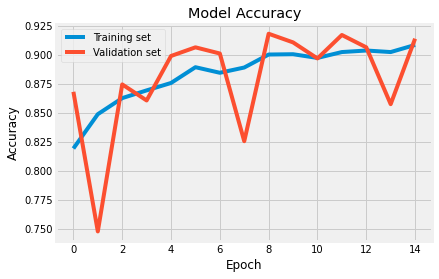

In [64]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.savefig("model_accuracy.png")

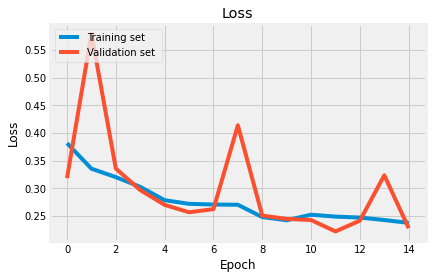

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set '], loc='upper left')
plt.savefig("model_loss.png")